In [1]:
#Basic shit
import re
import numpy as np
import random
import time
from datetime import datetime, timedelta
import math
from IPython.display import Image


#Dataframes + read data
import pickle
import json 
import geojson
import geocoder

import pandas as pd      #Package for handling large data structures
import geopandas as gpd  #http://localhost:8888/notebooks/KTH/GitHub/DF23_cycle/M_stat_all.ipynb#Package for handling geospatial data
from geopandas import GeoDataFrame, read_file
from pyproj import CRS   #coordinate reference system

#Shapes
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, shape
from shapely import wkt  #If the geo_data is in wkt-format, this package is needed to "read" that (wtk - well known text)
import shapely as shp
from shapely.geometry import box

#Plotting
import hvplot.pandas 
import matplotlib.pyplot as plt
from holoviews import opts, dim
import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':320, 'frame_width':320, 'cmap':'Viridis', 'colorbar':True}

import matplotlib.colors as colors
from mycolorpy import colorlist as mcp

#Gurobi
import gurobipy as gp
from gurobipy import GRB

In [7]:
with open('Data/CAB/25.3.4') as f:
    CAB = f.read().splitlines()
nodes = int(CAB[0])
CAB = CAB[1::]
coords = []
for i in range(nodes):
    coords.append(Point(CAB[i].split(" ")))
CAB = CAB[nodes::]

st = "qwertyuiopasdfghjklzxcvbnm"
id_l = []
for i in range(nodes):
    id_l.append(st[i])
df = pd.DataFrame(index=id_l)
for i in range(nodes):   
    df[id_l[i]] = [float(x) for x in CAB[i].split(" ")]    
CAB = CAB[25::]
df["geometry"] = coords

gdf = gpd.GeoDataFrame(df["geometry"], geometry='geometry')
gdf.set_crs('EPSG:32120', inplace=True);

for i in range(nodes):
    gdf[id_l[i]] = gdf.distance(gdf.geometry[i]) 

num_hubs = float(CAB[0])
chi = float(CAB[1])
alpha = float(CAB[2])
delta = float(CAB[3])
print("number of hubs =", num_hubs)
print("collection cost =", chi)
print("transfer cost =", alpha)
print("distribution cost =", delta)

number of hubs = 3.0
collection cost = 1.0
transfer cost = 0.4
distribution cost = 1.0


In [8]:
l = 500

for col in df.columns.tolist()[0:-1]:
    df[col] = round(df[col]/l)

In [9]:
l = 50
for col in gdf.columns.tolist()[1::]:
    gdf[col] = round(df[col]/l, 2)
    #print(gdf[col].nsmallest(2).tolist()[1])

In [10]:
gdf["total_flow"] = df.sum(axis=1, numeric_only=True)

df = pd.DataFrame(index = ["ARN", "GOT", "MAL"])
df["ARN"] = [0,2, 3]
df["GOT"] = [2,0,1]
df["MAL"] = [3,1,0]

#df["ARN"] = [0,1, 1]
#df["GOT"] = [1,0,1]
#df["MAL"] = [1,1,0]

df["ARN"] = [0,0, 4]
df["GOT"] = [0,0,0]
df["MAL"] = [4,0,0]
#df = pd.DataFrame(index = ["ARN", "GOT"])
#df["ARN"] = [0,4]
#df["GOT"] = [4,0]
#df["MAL"] = [3,2,0]

test = [[-1,0], [0,0], [1,0]]
n_nodes = len(df)
coords = []
for i in range(n_nodes):
    coords.append(Point(test[i]))

df["geometry"] = coords
    
# get distance matrix from point coordinates
gdf = gpd.GeoDataFrame(df, geometry='geometry')
for p in range(n_nodes):
    for q in range(n_nodes):
        gdf.iloc[p,q] = coords[p].distance(coords[q])
gdf["total_outflow"] = df.iloc[:,:-1].sum(axis=0)
gdf["total_inflow"] = df.iloc[:,:-1].sum(axis=1)

In [11]:
df.drop("geometry", axis=1, inplace=True)

planes_df = pd.DataFrame(index=["noplane", "plane1","plane2", "plane3"])
planes_df["cap"] = [0,20, 50,120]
planes_df["cost"] = [0, 3, 6,9 ]
planes_df["max_dist"] = [5,0.5,1.5,5]

planes_df = pd.DataFrame(index=["plane1","plane2"])

planes_df["cap"] = [5,10]
planes_df["cost"] = [2,0.5]
planes_df["max_dist"] = [1.5,1.6]
planes_df["land_cost"] = [1,1]

In [12]:
N = 5

names = ["plane" + str(i) for i in range(1,N+1)]
planes_df = pd.DataFrame(index=names)
cap = df["q"][1:N+1].tolist()
cap.sort()
planes_df["cap"] = cap
planes_df["cost"] = [1 for i in range(N)]
planes_df["max_dist"] = [0.5*i for i in range(1,N+1)]
planes_df["land_cost"] = [1 for i in range(N)]


In [13]:
#add a zero plane:
zero_plane = pd.DataFrame(index=["noplane"])
zero_plane["cap"] = 0
zero_plane["cost"] = 0
zero_plane["max_dist"] = planes_df["max_dist"].max()
zero_plane["land_cost"] = 0
planes_df = pd.concat([zero_plane, planes_df], ignore_index=False)

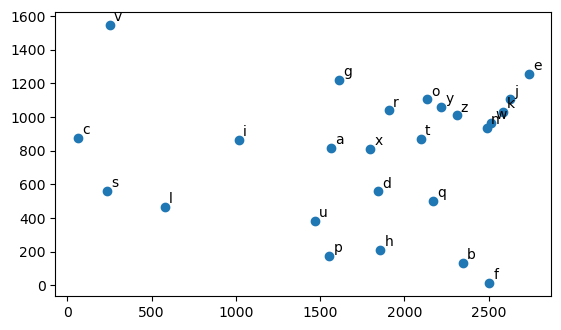

In [14]:
gdf["name"] = gdf.index.tolist()
ax = gdf.plot()

for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.name):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    
gdf.drop("name", axis=1, inplace=True)

In [15]:
planes = [n for n in planes_df.index.tolist()]
nodes = [i for i in df.index.tolist()]


    
max_dist = planes_df["max_dist"].max()
for node in nodes:
    min_dist = gdf[node].nsmallest(2).tolist()[-1]
    if min_dist > max_dist:
        print(node, "is to far away from the system")
        

arcs = [(i,j) for i in nodes for j in nodes if i!=j] #check all arcs
D_ij = {} #length of arc i,j
N_ij = {} #planes available between i and j
poss_arcs = [] #only use possible arcs
for tup in arcs:
    dist_ij = gdf[tup[0]][tup[1]] #length of arc
    n_list = []
    for plane in planes: #check if there are any planes that 
        if planes_df["max_dist"][plane]>dist_ij:
            n_list.append(plane)
    if len(n_list) > 0:
        poss_arcs.append(tup)
        D_ij[tup] = dist_ij
        N_ij[tup] = n_list

all_arcs = arcs
arcs = poss_arcs #only use possible arcs

commodities = [h for h in nodes]
W_h_i = {} #demand of commodity h at node i

for node in nodes:
    com = node
    total_flow_in = df.loc[node].sum()
    W_h_i[(com, node)] = -total_flow_in
    
    for com in nodes:
        if com != node:
            flow_out = df[node][com]
            W_h_i[(com,node)] = flow_out


K_n = {}
C_n = {}
Cl_n = {}
for plane in planes:
    K_n[plane] = planes_df["cap"][plane]
    C_n[plane] = planes_df["cost"][plane]
    Cl_n[plane] = planes_df["land_cost"][plane]


arc_plane_n_ij = [(n,i,j) for (i,j) in arcs for n in N_ij[(i,j)]]

C_n_ij = {}
for (n,i,j) in arc_plane_n_ij:
    C_n_ij[(n,i,j)] = C_n[n]*D_ij[(i,j)]


CN_ij = {} #continous cost
KN_ij = {} #

for arc in arcs:
    if len(N_ij[arc])>0:
        plane = N_ij[arc][-1]
        KN_ij[arc] = K_n[plane]
        P_N = C_n[plane]*D_ij[arc]#/K_n[plane]
        CN_ij[arc] = P_N
    else:
        KN_ij[arc] = 0
        CN_ij[arc] = 0



M = 1
for node in nodes:
    od = df[node].sum()
    M += od
M = max(max(KN_ij.values()), M) + 1

In [17]:
#model
try:
    m = gp.Model("airfleet")
    
    ###Variables:
    
    
    # Create variables
    f = m.addVars(commodities, arcs, name="F")
    g = m.addVars(arcs, vtype=GRB.BINARY, name="G") 
    a = m.addVars(arc_plane_n_ij, vtype=GRB.BINARY, name="A")
    ag = m.addVars(arcs, vtype=GRB.INTEGER, name="AG")
    u = m.addVars(arcs, name="U")
    u_help = m.addVars(arcs, lb=-M, name="U_help")
    f_arc = m.addVars(arcs, name = "farc")
    z_help = m.addVars(arcs, name="z_help") 
    hub_help = m.addVars(nodes, name="hub_help")
    hub = m.addVars(nodes, vtype=GRB.BINARY, name="hub")
    
    
    obj = a.prod(C_n_ij) + ag.prod(CN_ij) + a.sum("*","*","*") + ag.sum("*","*")
    #+ sum(sum(Cl_n[n]*a[n,i,j] for n in N_ij[(i,j)]) for (i,j) in arcs)
    
    
    #Objective function (a)
    m.setObjective(obj, GRB.MINIMIZE)

    # Flow-conservation constraints
    m.addConstrs(
        (f.sum(h, '*', i) + W_h_i[h, i] == f.sum(h, i, '*')
         for h in commodities for i in nodes), "node")
    
    #F assign total flow on arc
    m.addConstrs((f_arc[i,j] == f.sum("*", i, j) for (i,j) in arcs), "H")

    
    #G see if we use continous cost
    #m.addConstrs((g[i,j]*M >= f_arc[i,j] - KN_ij[(i,j)] for (i,j) in arcs), "8a")    # g=1 if flow> max capacity
    #m.addConstrs(((1-g[i,j])*M >= KN_ij[(i,j)]- f_arc[i,j] for (i,j) in arcs), "8b") # g=0 if flow < max capacity
    
    #A pick a plane
    m.addConstrs((f_arc[i,j] <= sum(K_n[n]*a[n,i,j] for n in N_ij[(i,j)]) + ag[i,j] for (i,j) in arcs), "9b") # ensure flow < capacity of the chosen plane
    m.addConstrs((sum(a[n,i,j] for n in N_ij[(i,j)]) + g[i,j] == 1 for (i,j) in arcs), "9a") # pick ONE plane OR pick g
    
    m.addConstrs(M_low*g[i,j] >= ag[i,j] for (i,j) in arcs) #ensure that if you pick ag, then g = 1 
    m.addConstrs(M_low*(1-g[i,j]) >= -ag[i,j] + 0.0001 for (i,j) in arcs) #else 0
    
    #fly the plane back
    #this will become infeasible when symmetry is not ensured
    m.addConstrs(a[n,i,j] == a[n,j,i] for (n,i,j) in arc_plane_n_ij)
    m.addConstrs(ag[i,j] == ag[j,i] for (i,j) in arcs)
    
    
    
    #U calculate how much flow should be covered by "plane g", i.e. with continous flow (all or nothing)
    #m.addConstrs((u_help[i,j] == f_arc[i,j] - sum(K_n[n]*a[n,i,j] for n in N_ij[(i,j)]) for (i,j) in arcs), "10") 
    #for i,j in arcs:
    #    m.addConstr((u[i,j] == gp.max_(u_help[i,j], constant=0))) # u = 0 if a plane "a" was chosen
                                                                  # u = f_arc if "g" was chosen 

    #HUB 
    # keep track of which arcs are being used
    #m.addConstrs((z_help[i,j] == sum(a[n,i,j] for n in N_ij[(i,j)][1::]) for (i,j) in arcs), "10")  # if a plane besides "noplane" or was chosen
                                                                                                    # this arc is being used
    # compute the total amount of arcs going into and out of each node
    #m.addConstrs((hub_help[i] == z_help.sum(i,"*") + z_help.sum("*",i) for i in nodes), "12a")
    
    # assign hub-status
    #M_nodes = (len(nodes) + 1)*2 # Just a value that will always be higher than hub_help
    #m.addConstrs((hub[i]*M_nodes >= hub_help[i]-2  for i in nodes), "12b")             # if "nodes in and out" > 2, hub=1
    #m.addConstrs(((1-hub[i])*M_nodes >= 2-hub_help[i] + 0.001 for i in nodes), "12c")  # if "nodes in and out" <= 2, hub=0
    
    
    m.optimize()
    #for v in m.getVars():
    #    print('%s %g' % (v.VarName, v.X))
    
    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6167 rows, 21252 columns and 59288 nonzeros
Model fingerprint: 0x75ab5b06
Variable types: 16845 continuous, 4407 integer (3827 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [2e-02, 2e+00]
  Bounds range     [1e+00, 2e+04]
  RHS range        [1e+00, 3e+03]
Found heuristic solution: objective 31269.420000
Presolve removed 4382 rows and 5882 columns
Presolve time: 0.15s
Presolved: 1785 rows, 15370 columns, 45820 nonzeros
Variable types: 14500 continuous, 870 integer (290 binary)

Root relaxation: objective 3.169317e+03, 7212 iterations, 1.84 seconds (1.16 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3169.31714   